In [1]:
import sage
from sklearn.model_selection import train_test_split


# Load data
df = sage.datasets.credit()

# Feature names and categorical columns (for CatBoost model)
feature_names = df.columns.tolist()[:-1]
categorical_columns = [
    'Checking Status', 'Credit History', 'Purpose', 'Credit Amount',
    'Savings Account/Bonds', 'Employment Since', 'Personal Status',
    'Debtors/Guarantors', 'Property Type', 'Other Installment Plans',
    'Housing Ownership', 'Job', 'Telephone', 'Foreign Worker'
]
categorical_inds = [feature_names.index(col) for col in categorical_columns]

# Split data
train, test = train_test_split(
    df.values, test_size=int(0.1 * len(df.values)), random_state=0)
train, val = train_test_split(
    train, test_size=int(0.1 * len(df.values)), random_state=0)
Y_train = train[:, -1].copy().astype(int)
Y_val = val[:, -1].copy().astype(int)
Y_test = test[:, -1].copy().astype(int)
train = train[:, :-1].copy()
val = val[:, :-1].copy()
test = test[:, :-1].copy()

In [2]:
import os

from catboost import CatBoostClassifier


model_filename = "../credit_model.cbm"

if os.path.isfile(model_filename):
    model = CatBoostClassifier()
    model.load_model(model_filename)
else:
    model = CatBoostClassifier(iterations=50, learning_rate=0.3, depth=3)
    model = model.fit(train, Y_train, categorical_inds, eval_set=(val, Y_val), verbose=False)
    model.save_model(model_filename)

In [3]:
import numpy as np
from sklearn.metrics import log_loss


# Calculate performance
p = np.array([np.sum(Y_train == i) for i in np.unique(Y_train)]) / len(Y_train)
base_ce = log_loss(Y_test.astype(int), p[np.newaxis].repeat(len(test), 0))
ce = log_loss(Y_test.astype(int), model.predict_proba(test))

print('Base rate cross entropy = {:.3f}'.format(base_ce))
print('Model cross entropy = {:.3f}'.format(ce))

Base rate cross entropy = 0.602
Model cross entropy = 0.457


In [4]:
from sklearn.metrics import roc_auc_score

print("ROC AUC Score = {:.3f}".format(roc_auc_score(Y_test, model.predict_proba(test)[:, 1])))

ROC AUC Score = 0.849


In [5]:
from sklearn.metrics import confusion_matrix

pred_test = model.predict_proba(test)
pred_test = np.argmax(pred_test, axis=1)

tn, fp, fn, tp = confusion_matrix(Y_test, pred_test, labels=[0,1]).ravel()
p = tp + fn
fnr = fn / p if p > 0.0 else np.float64(0.0)

print("False negative rate = {:.3f}".format(fnr))

False negative rate = 0.042


In [6]:
print("Classifier got {} positive examples wrong".format(int(round(Y_test.sum() * fnr))))

Classifier got 3 positive examples wrong


# Global FPR

In [8]:
# Setup and calculate with custom fairness-related loss function
imputer = sage.MarginalImputer(model, train[:512])
estimator_fpr = sage.PermutationEstimator(imputer, 'fpr')
%time sage_values_fpr = estimator_fpr(test, Y_test, verbose=True, n_permutations=51200)

TypeError: __call__() got an unexpected keyword argument 'n_pebrmutations'

In [9]:
# Print results
print("SAGE values using false positive rate as loss:", sage_values_fpr)

SAGE values using false positive rate as loss: SAGE Explanation(
  (Mean): [0.02 0.02 0.02 ... 0.02 0.02 0.02]
  (Std):  [8.63e-05 8.63e-05 8.61e-05 ... 8.50e-05 8.54e-05 8.52e-05]
)


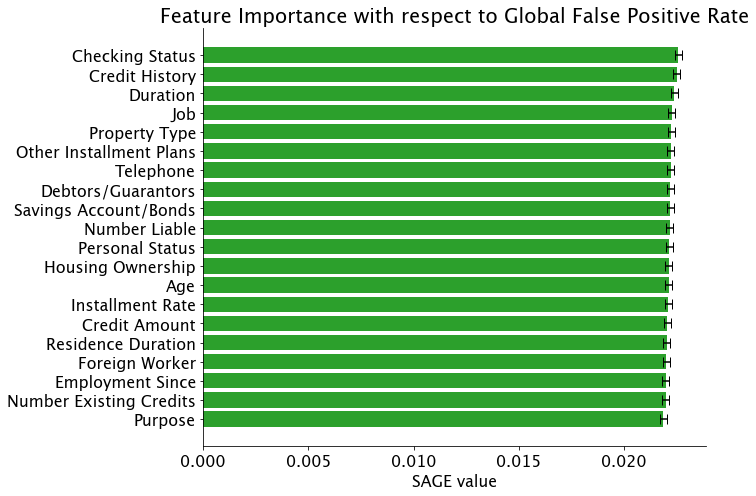

In [10]:
sage_values_fpr.plot(feature_names, title='Feature Importance with respect to Global False Positive Rate')

# Young group FPR

In [11]:
age_col = feature_names.index("Age")

In [12]:
where_young_train = train[:,age_col] <= 30
where_young_test = test[:,age_col] <= 30

test_young = test[where_young_test]
Y_test_young = Y_test[where_young_test]

In [13]:
num_young_train = train[where_young_train].shape[0]
n_permutations_young = num_young_train * 100
print(f"num_young_train = {num_young_train}, n_loops = {int(n_permutations_young / 512)}")

num_young_train = 331, n_loops = 64


In [14]:
# Setup and calculate with custom fairness-related loss function
imputer_young = sage.MarginalImputer(model, train[where_young_train])
estimator_young_fpr = sage.PermutationEstimator(imputer_young, 'fpr')
%time sage_values_young_fpr = estimator_young_fpr(test_young, Y_test_young, verbose=True, \
                                                  batch_size=num_young_train, n_permutations=n_permutations_young)

# Print results
print("SAGE values using false positive rate as loss:", sage_values_young_fpr)

  0%|          | 0/1 [00:00<?, ?it/s]

fp = 134, n = 134, fpr = 1.0
===> Iteration 0, Prev loss = 1.0 [outer loop]
fp = 134, n = 134, fpr = 1.0
	Loss = 1.0 [inner loop]
fp = 134, n = 134, fpr = 1.0
	Loss = 1.0 [inner loop]
fp = 134, n = 134, fpr = 1.0
	Loss = 1.0 [inner loop]
fp = 133, n = 134, fpr = 0.9925373134328358
	Loss = 0.9925373134328358 [inner loop]
fp = 133, n = 134, fpr = 0.9925373134328358
	Loss = 0.9925373134328358 [inner loop]
fp = 132, n = 134, fpr = 0.9850746268656716
	Loss = 0.9850746268656716 [inner loop]
fp = 127, n = 134, fpr = 0.9477611940298507
	Loss = 0.9477611940298507 [inner loop]
fp = 119, n = 134, fpr = 0.8880597014925373
	Loss = 0.8880597014925373 [inner loop]
fp = 119, n = 134, fpr = 0.8880597014925373
	Loss = 0.8880597014925373 [inner loop]
fp = 111, n = 134, fpr = 0.8283582089552238
	Loss = 0.8283582089552238 [inner loop]
fp = 103, n = 134, fpr = 0.7686567164179104
	Loss = 0.7686567164179104 [inner loop]
fp = 101, n = 134, fpr = 0.753731343283582
	Loss = 0.753731343283582 [inner loop]
fp = 96,

fp = 85, n = 139, fpr = 0.6115107913669064
	Loss = 0.6115107913669064 [inner loop]
fp = 78, n = 139, fpr = 0.5611510791366906
	Loss = 0.5611510791366906 [inner loop]
fp = 71, n = 139, fpr = 0.5107913669064749
	Loss = 0.5107913669064749 [inner loop]
StdDev Ratio = 0.2801 (Converge at 0.0250)
fp = 145, n = 145, fpr = 1.0
===> Iteration 5, Prev loss = 1.0 [outer loop]
fp = 145, n = 145, fpr = 1.0
	Loss = 1.0 [inner loop]
fp = 145, n = 145, fpr = 1.0
	Loss = 1.0 [inner loop]
fp = 143, n = 145, fpr = 0.9862068965517241
	Loss = 0.9862068965517241 [inner loop]
fp = 143, n = 145, fpr = 0.9862068965517241
	Loss = 0.9862068965517241 [inner loop]
fp = 142, n = 145, fpr = 0.9793103448275862
	Loss = 0.9793103448275862 [inner loop]
fp = 140, n = 145, fpr = 0.9655172413793104
	Loss = 0.9655172413793104 [inner loop]
fp = 135, n = 145, fpr = 0.9310344827586207
	Loss = 0.9310344827586207 [inner loop]
fp = 129, n = 145, fpr = 0.8896551724137931
	Loss = 0.8896551724137931 [inner loop]
fp = 124, n = 145, f

fp = 109, n = 136, fpr = 0.8014705882352942
	Loss = 0.8014705882352942 [inner loop]
fp = 110, n = 136, fpr = 0.8088235294117647
	Loss = 0.8088235294117647 [inner loop]
fp = 104, n = 136, fpr = 0.7647058823529411
	Loss = 0.7647058823529411 [inner loop]
fp = 96, n = 136, fpr = 0.7058823529411765
	Loss = 0.7058823529411765 [inner loop]
fp = 89, n = 136, fpr = 0.6544117647058824
	Loss = 0.6544117647058824 [inner loop]
fp = 81, n = 136, fpr = 0.5955882352941176
	Loss = 0.5955882352941176 [inner loop]
fp = 75, n = 136, fpr = 0.5514705882352942
	Loss = 0.5514705882352942 [inner loop]
fp = 66, n = 136, fpr = 0.4852941176470588
	Loss = 0.4852941176470588 [inner loop]
fp = 58, n = 136, fpr = 0.4264705882352941
	Loss = 0.4264705882352941 [inner loop]
StdDev Ratio = 0.1856 (Converge at 0.0250)
fp = 130, n = 130, fpr = 1.0
===> Iteration 10, Prev loss = 1.0 [outer loop]
fp = 130, n = 130, fpr = 1.0
	Loss = 1.0 [inner loop]
fp = 130, n = 130, fpr = 1.0
	Loss = 1.0 [inner loop]
fp = 129, n = 130, fpr

fp = 111, n = 150, fpr = 0.74
	Loss = 0.74 [inner loop]
fp = 106, n = 150, fpr = 0.7066666666666667
	Loss = 0.7066666666666667 [inner loop]
fp = 103, n = 150, fpr = 0.6866666666666666
	Loss = 0.6866666666666666 [inner loop]
fp = 95, n = 150, fpr = 0.6333333333333333
	Loss = 0.6333333333333333 [inner loop]
fp = 84, n = 150, fpr = 0.56
	Loss = 0.56 [inner loop]
fp = 76, n = 150, fpr = 0.5066666666666667
	Loss = 0.5066666666666667 [inner loop]
fp = 70, n = 150, fpr = 0.4666666666666667
	Loss = 0.4666666666666667 [inner loop]
StdDev Ratio = 0.1987 (Converge at 0.0250)
fp = 136, n = 136, fpr = 1.0
===> Iteration 15, Prev loss = 1.0 [outer loop]
fp = 136, n = 136, fpr = 1.0
	Loss = 1.0 [inner loop]
fp = 136, n = 136, fpr = 1.0
	Loss = 1.0 [inner loop]
fp = 136, n = 136, fpr = 1.0
	Loss = 1.0 [inner loop]
fp = 134, n = 136, fpr = 0.9852941176470589
	Loss = 0.9852941176470589 [inner loop]
fp = 132, n = 136, fpr = 0.9705882352941176
	Loss = 0.9705882352941176 [inner loop]
fp = 128, n = 136, fpr

fp = 108, n = 134, fpr = 0.8059701492537313
	Loss = 0.8059701492537313 [inner loop]
fp = 104, n = 134, fpr = 0.7761194029850746
	Loss = 0.7761194029850746 [inner loop]
fp = 102, n = 134, fpr = 0.7611940298507462
	Loss = 0.7611940298507462 [inner loop]
fp = 98, n = 134, fpr = 0.7313432835820896
	Loss = 0.7313432835820896 [inner loop]
fp = 93, n = 134, fpr = 0.6940298507462687
	Loss = 0.6940298507462687 [inner loop]
fp = 92, n = 134, fpr = 0.6865671641791045
	Loss = 0.6865671641791045 [inner loop]
fp = 85, n = 134, fpr = 0.6343283582089553
	Loss = 0.6343283582089553 [inner loop]
fp = 79, n = 134, fpr = 0.5895522388059702
	Loss = 0.5895522388059702 [inner loop]
fp = 71, n = 134, fpr = 0.5298507462686567
	Loss = 0.5298507462686567 [inner loop]
StdDev Ratio = 0.2029 (Converge at 0.0250)
fp = 135, n = 135, fpr = 1.0
===> Iteration 20, Prev loss = 1.0 [outer loop]
fp = 135, n = 135, fpr = 1.0
	Loss = 1.0 [inner loop]
fp = 133, n = 135, fpr = 0.9851851851851852
	Loss = 0.9851851851851852 [inne

fp = 129, n = 138, fpr = 0.9347826086956522
	Loss = 0.9347826086956522 [inner loop]
fp = 128, n = 138, fpr = 0.927536231884058
	Loss = 0.927536231884058 [inner loop]
fp = 126, n = 138, fpr = 0.9130434782608695
	Loss = 0.9130434782608695 [inner loop]
fp = 123, n = 138, fpr = 0.8913043478260869
	Loss = 0.8913043478260869 [inner loop]
fp = 123, n = 138, fpr = 0.8913043478260869
	Loss = 0.8913043478260869 [inner loop]
fp = 116, n = 138, fpr = 0.8405797101449275
	Loss = 0.8405797101449275 [inner loop]
fp = 111, n = 138, fpr = 0.8043478260869565
	Loss = 0.8043478260869565 [inner loop]
fp = 107, n = 138, fpr = 0.7753623188405797
	Loss = 0.7753623188405797 [inner loop]
fp = 101, n = 138, fpr = 0.7318840579710145
	Loss = 0.7318840579710145 [inner loop]
fp = 94, n = 138, fpr = 0.6811594202898551
	Loss = 0.6811594202898551 [inner loop]
fp = 92, n = 138, fpr = 0.6666666666666666
	Loss = 0.6666666666666666 [inner loop]
fp = 88, n = 138, fpr = 0.6376811594202898
	Loss = 0.6376811594202898 [inner loo

fp = 141, n = 141, fpr = 1.0
===> Iteration 29, Prev loss = 1.0 [outer loop]
fp = 141, n = 141, fpr = 1.0
	Loss = 1.0 [inner loop]
fp = 140, n = 141, fpr = 0.9929078014184397
	Loss = 0.9929078014184397 [inner loop]
fp = 140, n = 141, fpr = 0.9929078014184397
	Loss = 0.9929078014184397 [inner loop]
fp = 140, n = 141, fpr = 0.9929078014184397
	Loss = 0.9929078014184397 [inner loop]
fp = 138, n = 141, fpr = 0.9787234042553191
	Loss = 0.9787234042553191 [inner loop]
fp = 136, n = 141, fpr = 0.9645390070921985
	Loss = 0.9645390070921985 [inner loop]
fp = 135, n = 141, fpr = 0.9574468085106383
	Loss = 0.9574468085106383 [inner loop]
fp = 131, n = 141, fpr = 0.9290780141843972
	Loss = 0.9290780141843972 [inner loop]
fp = 128, n = 141, fpr = 0.9078014184397163
	Loss = 0.9078014184397163 [inner loop]
fp = 124, n = 141, fpr = 0.8794326241134752
	Loss = 0.8794326241134752 [inner loop]
fp = 120, n = 141, fpr = 0.851063829787234
	Loss = 0.851063829787234 [inner loop]
fp = 115, n = 141, fpr = 0.8156

fp = 90, n = 129, fpr = 0.6976744186046512
	Loss = 0.6976744186046512 [inner loop]
fp = 80, n = 129, fpr = 0.6201550387596899
	Loss = 0.6201550387596899 [inner loop]
fp = 67, n = 129, fpr = 0.5193798449612403
	Loss = 0.5193798449612403 [inner loop]
fp = 58, n = 129, fpr = 0.4496124031007752
	Loss = 0.4496124031007752 [inner loop]
StdDev Ratio = 0.1960 (Converge at 0.0250)
fp = 152, n = 152, fpr = 1.0
===> Iteration 34, Prev loss = 1.0 [outer loop]
fp = 152, n = 152, fpr = 1.0
	Loss = 1.0 [inner loop]
fp = 151, n = 152, fpr = 0.993421052631579
	Loss = 0.993421052631579 [inner loop]
fp = 150, n = 152, fpr = 0.9868421052631579
	Loss = 0.9868421052631579 [inner loop]
fp = 150, n = 152, fpr = 0.9868421052631579
	Loss = 0.9868421052631579 [inner loop]
fp = 150, n = 152, fpr = 0.9868421052631579
	Loss = 0.9868421052631579 [inner loop]
fp = 144, n = 152, fpr = 0.9473684210526315
	Loss = 0.9473684210526315 [inner loop]
fp = 141, n = 152, fpr = 0.9276315789473685
	Loss = 0.9276315789473685 [inne

fp = 117, n = 137, fpr = 0.8540145985401459
	Loss = 0.8540145985401459 [inner loop]
fp = 112, n = 137, fpr = 0.8175182481751825
	Loss = 0.8175182481751825 [inner loop]
fp = 112, n = 137, fpr = 0.8175182481751825
	Loss = 0.8175182481751825 [inner loop]
fp = 105, n = 137, fpr = 0.7664233576642335
	Loss = 0.7664233576642335 [inner loop]
fp = 102, n = 137, fpr = 0.7445255474452555
	Loss = 0.7445255474452555 [inner loop]
fp = 98, n = 137, fpr = 0.7153284671532847
	Loss = 0.7153284671532847 [inner loop]
fp = 95, n = 137, fpr = 0.6934306569343066
	Loss = 0.6934306569343066 [inner loop]
fp = 85, n = 137, fpr = 0.6204379562043796
	Loss = 0.6204379562043796 [inner loop]
fp = 80, n = 137, fpr = 0.583941605839416
	Loss = 0.583941605839416 [inner loop]
fp = 69, n = 137, fpr = 0.5036496350364964
	Loss = 0.5036496350364964 [inner loop]
StdDev Ratio = 0.2127 (Converge at 0.0250)
fp = 145, n = 145, fpr = 1.0
===> Iteration 39, Prev loss = 1.0 [outer loop]
fp = 145, n = 145, fpr = 1.0
	Loss = 1.0 [inner

fp = 132, n = 138, fpr = 0.9565217391304348
	Loss = 0.9565217391304348 [inner loop]
fp = 130, n = 138, fpr = 0.9420289855072463
	Loss = 0.9420289855072463 [inner loop]
fp = 124, n = 138, fpr = 0.8985507246376812
	Loss = 0.8985507246376812 [inner loop]
fp = 121, n = 138, fpr = 0.8768115942028986
	Loss = 0.8768115942028986 [inner loop]
fp = 119, n = 138, fpr = 0.8623188405797102
	Loss = 0.8623188405797102 [inner loop]
fp = 121, n = 138, fpr = 0.8768115942028986
	Loss = 0.8768115942028986 [inner loop]
fp = 120, n = 138, fpr = 0.8695652173913043
	Loss = 0.8695652173913043 [inner loop]
fp = 120, n = 138, fpr = 0.8695652173913043
	Loss = 0.8695652173913043 [inner loop]
fp = 112, n = 138, fpr = 0.8115942028985508
	Loss = 0.8115942028985508 [inner loop]
fp = 104, n = 138, fpr = 0.7536231884057971
	Loss = 0.7536231884057971 [inner loop]
fp = 101, n = 138, fpr = 0.7318840579710145
	Loss = 0.7318840579710145 [inner loop]
fp = 87, n = 138, fpr = 0.6304347826086957
	Loss = 0.6304347826086957 [inner

fp = 125, n = 125, fpr = 1.0
	Loss = 1.0 [inner loop]
fp = 125, n = 125, fpr = 1.0
	Loss = 1.0 [inner loop]
fp = 125, n = 125, fpr = 1.0
	Loss = 1.0 [inner loop]
fp = 125, n = 125, fpr = 1.0
	Loss = 1.0 [inner loop]
fp = 122, n = 125, fpr = 0.976
	Loss = 0.976 [inner loop]
fp = 118, n = 125, fpr = 0.944
	Loss = 0.944 [inner loop]
fp = 116, n = 125, fpr = 0.928
	Loss = 0.928 [inner loop]
fp = 114, n = 125, fpr = 0.912
	Loss = 0.912 [inner loop]
fp = 113, n = 125, fpr = 0.904
	Loss = 0.904 [inner loop]
fp = 109, n = 125, fpr = 0.872
	Loss = 0.872 [inner loop]
fp = 107, n = 125, fpr = 0.856
	Loss = 0.856 [inner loop]
fp = 101, n = 125, fpr = 0.808
	Loss = 0.808 [inner loop]
fp = 95, n = 125, fpr = 0.76
	Loss = 0.76 [inner loop]
fp = 91, n = 125, fpr = 0.728
	Loss = 0.728 [inner loop]
fp = 88, n = 125, fpr = 0.704
	Loss = 0.704 [inner loop]
fp = 85, n = 125, fpr = 0.68
	Loss = 0.68 [inner loop]
fp = 81, n = 125, fpr = 0.648
	Loss = 0.648 [inner loop]
fp = 75, n = 125, fpr = 0.6
	Loss = 0.6

fp = 139, n = 140, fpr = 0.9928571428571429
	Loss = 0.9928571428571429 [inner loop]
fp = 137, n = 140, fpr = 0.9785714285714285
	Loss = 0.9785714285714285 [inner loop]
fp = 135, n = 140, fpr = 0.9642857142857143
	Loss = 0.9642857142857143 [inner loop]
fp = 132, n = 140, fpr = 0.9428571428571428
	Loss = 0.9428571428571428 [inner loop]
fp = 131, n = 140, fpr = 0.9357142857142857
	Loss = 0.9357142857142857 [inner loop]
fp = 129, n = 140, fpr = 0.9214285714285714
	Loss = 0.9214285714285714 [inner loop]
fp = 128, n = 140, fpr = 0.9142857142857143
	Loss = 0.9142857142857143 [inner loop]
fp = 124, n = 140, fpr = 0.8857142857142857
	Loss = 0.8857142857142857 [inner loop]
fp = 119, n = 140, fpr = 0.85
	Loss = 0.85 [inner loop]
fp = 114, n = 140, fpr = 0.8142857142857143
	Loss = 0.8142857142857143 [inner loop]
fp = 114, n = 140, fpr = 0.8142857142857143
	Loss = 0.8142857142857143 [inner loop]
fp = 109, n = 140, fpr = 0.7785714285714286
	Loss = 0.7785714285714286 [inner loop]
fp = 106, n = 140, f

fp = 126, n = 126, fpr = 1.0
	Loss = 1.0 [inner loop]
fp = 126, n = 126, fpr = 1.0
	Loss = 1.0 [inner loop]
fp = 126, n = 126, fpr = 1.0
	Loss = 1.0 [inner loop]
fp = 123, n = 126, fpr = 0.9761904761904762
	Loss = 0.9761904761904762 [inner loop]
fp = 120, n = 126, fpr = 0.9523809523809523
	Loss = 0.9523809523809523 [inner loop]
fp = 119, n = 126, fpr = 0.9444444444444444
	Loss = 0.9444444444444444 [inner loop]
fp = 117, n = 126, fpr = 0.9285714285714286
	Loss = 0.9285714285714286 [inner loop]
fp = 115, n = 126, fpr = 0.9126984126984127
	Loss = 0.9126984126984127 [inner loop]
fp = 113, n = 126, fpr = 0.8968253968253969
	Loss = 0.8968253968253969 [inner loop]
fp = 111, n = 126, fpr = 0.8809523809523809
	Loss = 0.8809523809523809 [inner loop]
fp = 106, n = 126, fpr = 0.8412698412698413
	Loss = 0.8412698412698413 [inner loop]
fp = 100, n = 126, fpr = 0.7936507936507936
	Loss = 0.7936507936507936 [inner loop]
fp = 98, n = 126, fpr = 0.7777777777777778
	Loss = 0.7777777777777778 [inner loop]

fp = 79, n = 147, fpr = 0.5374149659863946
	Loss = 0.5374149659863946 [inner loop]
fp = 74, n = 147, fpr = 0.5034013605442177
	Loss = 0.5034013605442177 [inner loop]
fp = 70, n = 147, fpr = 0.47619047619047616
	Loss = 0.47619047619047616 [inner loop]
StdDev Ratio = 0.1842 (Converge at 0.0250)
fp = 146, n = 146, fpr = 1.0
===> Iteration 63, Prev loss = 1.0 [outer loop]
fp = 146, n = 146, fpr = 1.0
	Loss = 1.0 [inner loop]
fp = 145, n = 146, fpr = 0.9931506849315068
	Loss = 0.9931506849315068 [inner loop]
fp = 144, n = 146, fpr = 0.9863013698630136
	Loss = 0.9863013698630136 [inner loop]
fp = 143, n = 146, fpr = 0.9794520547945206
	Loss = 0.9794520547945206 [inner loop]
fp = 140, n = 146, fpr = 0.958904109589041
	Loss = 0.958904109589041 [inner loop]
fp = 141, n = 146, fpr = 0.9657534246575342
	Loss = 0.9657534246575342 [inner loop]
fp = 142, n = 146, fpr = 0.9726027397260274
	Loss = 0.9726027397260274 [inner loop]
fp = 138, n = 146, fpr = 0.9452054794520548
	Loss = 0.9452054794520548 [i

fp = 107, n = 141, fpr = 0.7588652482269503
	Loss = 0.7588652482269503 [inner loop]
fp = 101, n = 141, fpr = 0.7163120567375887
	Loss = 0.7163120567375887 [inner loop]
fp = 99, n = 141, fpr = 0.7021276595744681
	Loss = 0.7021276595744681 [inner loop]
fp = 93, n = 141, fpr = 0.6595744680851063
	Loss = 0.6595744680851063 [inner loop]
fp = 85, n = 141, fpr = 0.6028368794326241
	Loss = 0.6028368794326241 [inner loop]
fp = 78, n = 141, fpr = 0.5531914893617021
	Loss = 0.5531914893617021 [inner loop]
fp = 75, n = 141, fpr = 0.5319148936170213
	Loss = 0.5319148936170213 [inner loop]
fp = 69, n = 141, fpr = 0.48936170212765956
	Loss = 0.48936170212765956 [inner loop]
StdDev Ratio = 0.1898 (Converge at 0.0250)
fp = 141, n = 141, fpr = 1.0
===> Iteration 68, Prev loss = 1.0 [outer loop]
fp = 141, n = 141, fpr = 1.0
	Loss = 1.0 [inner loop]
fp = 141, n = 141, fpr = 1.0
	Loss = 1.0 [inner loop]
fp = 139, n = 141, fpr = 0.9858156028368794
	Loss = 0.9858156028368794 [inner loop]
fp = 139, n = 141, f

fp = 126, n = 138, fpr = 0.9130434782608695
	Loss = 0.9130434782608695 [inner loop]
fp = 123, n = 138, fpr = 0.8913043478260869
	Loss = 0.8913043478260869 [inner loop]
fp = 121, n = 138, fpr = 0.8768115942028986
	Loss = 0.8768115942028986 [inner loop]
fp = 117, n = 138, fpr = 0.8478260869565217
	Loss = 0.8478260869565217 [inner loop]
fp = 114, n = 138, fpr = 0.8260869565217391
	Loss = 0.8260869565217391 [inner loop]
fp = 108, n = 138, fpr = 0.782608695652174
	Loss = 0.782608695652174 [inner loop]
fp = 100, n = 138, fpr = 0.7246376811594203
	Loss = 0.7246376811594203 [inner loop]
fp = 94, n = 138, fpr = 0.6811594202898551
	Loss = 0.6811594202898551 [inner loop]
fp = 91, n = 138, fpr = 0.6594202898550725
	Loss = 0.6594202898550725 [inner loop]
fp = 84, n = 138, fpr = 0.6086956521739131
	Loss = 0.6086956521739131 [inner loop]
fp = 73, n = 138, fpr = 0.5289855072463768
	Loss = 0.5289855072463768 [inner loop]
fp = 67, n = 138, fpr = 0.4855072463768116
	Loss = 0.4855072463768116 [inner loop]

fp = 134, n = 141, fpr = 0.950354609929078
	Loss = 0.950354609929078 [inner loop]
fp = 134, n = 141, fpr = 0.950354609929078
	Loss = 0.950354609929078 [inner loop]
fp = 133, n = 141, fpr = 0.9432624113475178
	Loss = 0.9432624113475178 [inner loop]
fp = 131, n = 141, fpr = 0.9290780141843972
	Loss = 0.9290780141843972 [inner loop]
fp = 129, n = 141, fpr = 0.9148936170212766
	Loss = 0.9148936170212766 [inner loop]
fp = 127, n = 141, fpr = 0.900709219858156
	Loss = 0.900709219858156 [inner loop]
fp = 125, n = 141, fpr = 0.8865248226950354
	Loss = 0.8865248226950354 [inner loop]
fp = 121, n = 141, fpr = 0.8581560283687943
	Loss = 0.8581560283687943 [inner loop]
fp = 116, n = 141, fpr = 0.8226950354609929
	Loss = 0.8226950354609929 [inner loop]
fp = 114, n = 141, fpr = 0.8085106382978723
	Loss = 0.8085106382978723 [inner loop]
fp = 106, n = 141, fpr = 0.75177304964539
	Loss = 0.75177304964539 [inner loop]
fp = 101, n = 141, fpr = 0.7163120567375887
	Loss = 0.7163120567375887 [inner loop]
fp

fp = 138, n = 138, fpr = 1.0
===> Iteration 82, Prev loss = 1.0 [outer loop]
fp = 138, n = 138, fpr = 1.0
	Loss = 1.0 [inner loop]
fp = 138, n = 138, fpr = 1.0
	Loss = 1.0 [inner loop]
fp = 136, n = 138, fpr = 0.9855072463768116
	Loss = 0.9855072463768116 [inner loop]
fp = 133, n = 138, fpr = 0.9637681159420289
	Loss = 0.9637681159420289 [inner loop]
fp = 131, n = 138, fpr = 0.9492753623188406
	Loss = 0.9492753623188406 [inner loop]
fp = 131, n = 138, fpr = 0.9492753623188406
	Loss = 0.9492753623188406 [inner loop]
fp = 131, n = 138, fpr = 0.9492753623188406
	Loss = 0.9492753623188406 [inner loop]
fp = 131, n = 138, fpr = 0.9492753623188406
	Loss = 0.9492753623188406 [inner loop]
fp = 127, n = 138, fpr = 0.9202898550724637
	Loss = 0.9202898550724637 [inner loop]
fp = 124, n = 138, fpr = 0.8985507246376812
	Loss = 0.8985507246376812 [inner loop]
fp = 114, n = 138, fpr = 0.8260869565217391
	Loss = 0.8260869565217391 [inner loop]
fp = 108, n = 138, fpr = 0.782608695652174
	Loss = 0.782608

fp = 82, n = 138, fpr = 0.5942028985507246
	Loss = 0.5942028985507246 [inner loop]
fp = 72, n = 138, fpr = 0.5217391304347826
	Loss = 0.5217391304347826 [inner loop]
fp = 61, n = 138, fpr = 0.4420289855072464
	Loss = 0.4420289855072464 [inner loop]
StdDev Ratio = 0.1751 (Converge at 0.0250)
fp = 134, n = 134, fpr = 1.0
===> Iteration 87, Prev loss = 1.0 [outer loop]
fp = 134, n = 134, fpr = 1.0
	Loss = 1.0 [inner loop]
fp = 133, n = 134, fpr = 0.9925373134328358
	Loss = 0.9925373134328358 [inner loop]
fp = 133, n = 134, fpr = 0.9925373134328358
	Loss = 0.9925373134328358 [inner loop]
fp = 132, n = 134, fpr = 0.9850746268656716
	Loss = 0.9850746268656716 [inner loop]
fp = 132, n = 134, fpr = 0.9850746268656716
	Loss = 0.9850746268656716 [inner loop]
fp = 131, n = 134, fpr = 0.9776119402985075
	Loss = 0.9776119402985075 [inner loop]
fp = 126, n = 134, fpr = 0.9402985074626866
	Loss = 0.9402985074626866 [inner loop]
fp = 126, n = 134, fpr = 0.9402985074626866
	Loss = 0.9402985074626866 [i

fp = 96, n = 129, fpr = 0.7441860465116279
	Loss = 0.7441860465116279 [inner loop]
fp = 88, n = 129, fpr = 0.6821705426356589
	Loss = 0.6821705426356589 [inner loop]
fp = 87, n = 129, fpr = 0.6744186046511628
	Loss = 0.6744186046511628 [inner loop]
fp = 80, n = 129, fpr = 0.6201550387596899
	Loss = 0.6201550387596899 [inner loop]
fp = 77, n = 129, fpr = 0.5968992248062015
	Loss = 0.5968992248062015 [inner loop]
fp = 72, n = 129, fpr = 0.5581395348837209
	Loss = 0.5581395348837209 [inner loop]
fp = 62, n = 129, fpr = 0.4806201550387597
	Loss = 0.4806201550387597 [inner loop]
fp = 55, n = 129, fpr = 0.4263565891472868
	Loss = 0.4263565891472868 [inner loop]
StdDev Ratio = 0.1639 (Converge at 0.0250)
fp = 135, n = 135, fpr = 1.0
===> Iteration 92, Prev loss = 1.0 [outer loop]
fp = 135, n = 135, fpr = 1.0
	Loss = 1.0 [inner loop]
fp = 134, n = 135, fpr = 0.9925925925925926
	Loss = 0.9925925925925926 [inner loop]
fp = 132, n = 135, fpr = 0.9777777777777777
	Loss = 0.9777777777777777 [inner 

fp = 111, n = 123, fpr = 0.9024390243902439
	Loss = 0.9024390243902439 [inner loop]
fp = 110, n = 123, fpr = 0.8943089430894309
	Loss = 0.8943089430894309 [inner loop]
fp = 106, n = 123, fpr = 0.8617886178861789
	Loss = 0.8617886178861789 [inner loop]
fp = 103, n = 123, fpr = 0.8373983739837398
	Loss = 0.8373983739837398 [inner loop]
fp = 97, n = 123, fpr = 0.7886178861788617
	Loss = 0.7886178861788617 [inner loop]
fp = 97, n = 123, fpr = 0.7886178861788617
	Loss = 0.7886178861788617 [inner loop]
fp = 90, n = 123, fpr = 0.7317073170731707
	Loss = 0.7317073170731707 [inner loop]
fp = 88, n = 123, fpr = 0.7154471544715447
	Loss = 0.7154471544715447 [inner loop]
fp = 84, n = 123, fpr = 0.6829268292682927
	Loss = 0.6829268292682927 [inner loop]
fp = 78, n = 123, fpr = 0.6341463414634146
	Loss = 0.6341463414634146 [inner loop]
fp = 70, n = 123, fpr = 0.5691056910569106
	Loss = 0.5691056910569106 [inner loop]
fp = 65, n = 123, fpr = 0.5284552845528455
	Loss = 0.5284552845528455 [inner loop]


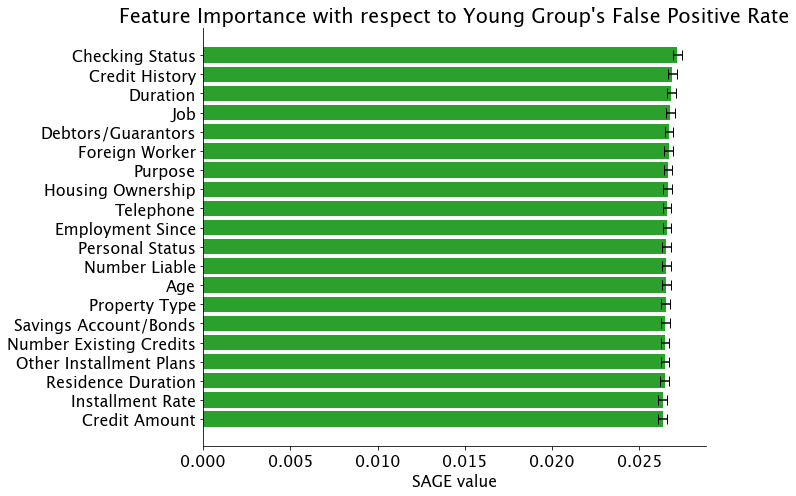

In [15]:
sage_values_young_fpr.plot(feature_names, title='Feature Importance with respect to Young Group\'s False Positive Rate')

# Old group FPR

In [16]:
where_old_train = train[:,age_col] > 30
where_old_test = np.invert(where_young_test)

test_old = test[where_old_test]
Y_test_old = Y_test[where_old_test]

In [17]:
num_old_train = train[where_old_train].shape[0]
n_permutations_old = num_old_train * 100
print(f"num_old_train = {num_old_train}, n_loops = {int(n_permutations_old / 512)}")

num_old_train = 469, n_loops = 91


In [18]:
# Setup and calculate with custom fairness-related loss function
imputer_old = sage.MarginalImputer(model, train[where_old_train])
estimator_old_fpr = sage.PermutationEstimator(imputer_old, 'fpr')
%time sage_values_old_fpr = estimator_old_fpr(test_old, Y_test_old, verbose=True, \
                                              batch_size=num_old_train, n_permutations=n_permutations_old)

# Print results
print("SAGE values using false positive rate as loss:", sage_values_old_fpr)

  0%|          | 0/1 [00:00<?, ?it/s]

fp = 93, n = 93, fpr = 1.0
===> Iteration 0, Prev loss = 1.0 [outer loop]
fp = 93, n = 93, fpr = 1.0
	Loss = 1.0 [inner loop]
fp = 93, n = 93, fpr = 1.0
	Loss = 1.0 [inner loop]
fp = 93, n = 93, fpr = 1.0
	Loss = 1.0 [inner loop]
fp = 93, n = 93, fpr = 1.0
	Loss = 1.0 [inner loop]
fp = 88, n = 93, fpr = 0.946236559139785
	Loss = 0.946236559139785 [inner loop]
fp = 88, n = 93, fpr = 0.946236559139785
	Loss = 0.946236559139785 [inner loop]
fp = 85, n = 93, fpr = 0.9139784946236559
	Loss = 0.9139784946236559 [inner loop]
fp = 81, n = 93, fpr = 0.8709677419354839
	Loss = 0.8709677419354839 [inner loop]
fp = 82, n = 93, fpr = 0.8817204301075269
	Loss = 0.8817204301075269 [inner loop]
fp = 80, n = 93, fpr = 0.8602150537634409
	Loss = 0.8602150537634409 [inner loop]
fp = 79, n = 93, fpr = 0.8494623655913979
	Loss = 0.8494623655913979 [inner loop]
fp = 76, n = 93, fpr = 0.8172043010752689
	Loss = 0.8172043010752689 [inner loop]
fp = 73, n = 93, fpr = 0.7849462365591398
	Loss = 0.78494623655913

fp = 68, n = 111, fpr = 0.6126126126126126
	Loss = 0.6126126126126126 [inner loop]
StdDev Ratio = 0.2951 (Converge at 0.0250)
fp = 86, n = 86, fpr = 1.0
===> Iteration 5, Prev loss = 1.0 [outer loop]
fp = 86, n = 86, fpr = 1.0
	Loss = 1.0 [inner loop]
fp = 86, n = 86, fpr = 1.0
	Loss = 1.0 [inner loop]
fp = 86, n = 86, fpr = 1.0
	Loss = 1.0 [inner loop]
fp = 86, n = 86, fpr = 1.0
	Loss = 1.0 [inner loop]
fp = 85, n = 86, fpr = 0.9883720930232558
	Loss = 0.9883720930232558 [inner loop]
fp = 85, n = 86, fpr = 0.9883720930232558
	Loss = 0.9883720930232558 [inner loop]
fp = 81, n = 86, fpr = 0.9418604651162791
	Loss = 0.9418604651162791 [inner loop]
fp = 82, n = 86, fpr = 0.9534883720930233
	Loss = 0.9534883720930233 [inner loop]
fp = 75, n = 86, fpr = 0.872093023255814
	Loss = 0.872093023255814 [inner loop]
fp = 76, n = 86, fpr = 0.8837209302325582
	Loss = 0.8837209302325582 [inner loop]
fp = 72, n = 86, fpr = 0.8372093023255814
	Loss = 0.8372093023255814 [inner loop]
fp = 71, n = 86, fpr

fp = 87, n = 116, fpr = 0.75
	Loss = 0.75 [inner loop]
fp = 83, n = 116, fpr = 0.7155172413793104
	Loss = 0.7155172413793104 [inner loop]
fp = 76, n = 116, fpr = 0.6551724137931034
	Loss = 0.6551724137931034 [inner loop]
fp = 73, n = 116, fpr = 0.6293103448275862
	Loss = 0.6293103448275862 [inner loop]
fp = 69, n = 116, fpr = 0.5948275862068966
	Loss = 0.5948275862068966 [inner loop]
StdDev Ratio = 0.2742 (Converge at 0.0250)
fp = 105, n = 105, fpr = 1.0
===> Iteration 10, Prev loss = 1.0 [outer loop]
fp = 105, n = 105, fpr = 1.0
	Loss = 1.0 [inner loop]
fp = 104, n = 105, fpr = 0.9904761904761905
	Loss = 0.9904761904761905 [inner loop]
fp = 103, n = 105, fpr = 0.9809523809523809
	Loss = 0.9809523809523809 [inner loop]
fp = 101, n = 105, fpr = 0.9619047619047619
	Loss = 0.9619047619047619 [inner loop]
fp = 100, n = 105, fpr = 0.9523809523809523
	Loss = 0.9523809523809523 [inner loop]
fp = 97, n = 105, fpr = 0.9238095238095239
	Loss = 0.9238095238095239 [inner loop]
fp = 95, n = 105, fp

fp = 99, n = 128, fpr = 0.7734375
	Loss = 0.7734375 [inner loop]
fp = 100, n = 128, fpr = 0.78125
	Loss = 0.78125 [inner loop]
fp = 97, n = 128, fpr = 0.7578125
	Loss = 0.7578125 [inner loop]
fp = 96, n = 128, fpr = 0.75
	Loss = 0.75 [inner loop]
fp = 94, n = 128, fpr = 0.734375
	Loss = 0.734375 [inner loop]
fp = 89, n = 128, fpr = 0.6953125
	Loss = 0.6953125 [inner loop]
fp = 87, n = 128, fpr = 0.6796875
	Loss = 0.6796875 [inner loop]
StdDev Ratio = 0.3285 (Converge at 0.0250)
fp = 91, n = 91, fpr = 1.0
===> Iteration 15, Prev loss = 1.0 [outer loop]
fp = 91, n = 91, fpr = 1.0
	Loss = 1.0 [inner loop]
fp = 90, n = 91, fpr = 0.989010989010989
	Loss = 0.989010989010989 [inner loop]
fp = 90, n = 91, fpr = 0.989010989010989
	Loss = 0.989010989010989 [inner loop]
fp = 90, n = 91, fpr = 0.989010989010989
	Loss = 0.989010989010989 [inner loop]
fp = 89, n = 91, fpr = 0.978021978021978
	Loss = 0.978021978021978 [inner loop]
fp = 89, n = 91, fpr = 0.978021978021978
	Loss = 0.978021978021978 [in

fp = 67, n = 86, fpr = 0.7790697674418605
	Loss = 0.7790697674418605 [inner loop]
fp = 64, n = 86, fpr = 0.7441860465116279
	Loss = 0.7441860465116279 [inner loop]
fp = 61, n = 86, fpr = 0.7093023255813954
	Loss = 0.7093023255813954 [inner loop]
fp = 58, n = 86, fpr = 0.6744186046511628
	Loss = 0.6744186046511628 [inner loop]
fp = 55, n = 86, fpr = 0.6395348837209303
	Loss = 0.6395348837209303 [inner loop]
fp = 53, n = 86, fpr = 0.6162790697674418
	Loss = 0.6162790697674418 [inner loop]
fp = 51, n = 86, fpr = 0.5930232558139535
	Loss = 0.5930232558139535 [inner loop]
fp = 54, n = 86, fpr = 0.627906976744186
	Loss = 0.627906976744186 [inner loop]
StdDev Ratio = 0.3662 (Converge at 0.0250)
fp = 96, n = 96, fpr = 1.0
===> Iteration 20, Prev loss = 1.0 [outer loop]
fp = 96, n = 96, fpr = 1.0
	Loss = 1.0 [inner loop]
fp = 96, n = 96, fpr = 1.0
	Loss = 1.0 [inner loop]
fp = 94, n = 96, fpr = 0.9791666666666666
	Loss = 0.9791666666666666 [inner loop]
fp = 91, n = 96, fpr = 0.9479166666666666


fp = 74, n = 99, fpr = 0.7474747474747475
	Loss = 0.7474747474747475 [inner loop]
fp = 72, n = 99, fpr = 0.7272727272727273
	Loss = 0.7272727272727273 [inner loop]
fp = 69, n = 99, fpr = 0.696969696969697
	Loss = 0.696969696969697 [inner loop]
StdDev Ratio = 0.3295 (Converge at 0.0250)
fp = 108, n = 108, fpr = 1.0
===> Iteration 25, Prev loss = 1.0 [outer loop]
fp = 108, n = 108, fpr = 1.0
	Loss = 1.0 [inner loop]
fp = 108, n = 108, fpr = 1.0
	Loss = 1.0 [inner loop]
fp = 108, n = 108, fpr = 1.0
	Loss = 1.0 [inner loop]
fp = 106, n = 108, fpr = 0.9814814814814815
	Loss = 0.9814814814814815 [inner loop]
fp = 104, n = 108, fpr = 0.9629629629629629
	Loss = 0.9629629629629629 [inner loop]
fp = 101, n = 108, fpr = 0.9351851851851852
	Loss = 0.9351851851851852 [inner loop]
fp = 99, n = 108, fpr = 0.9166666666666666
	Loss = 0.9166666666666666 [inner loop]
fp = 95, n = 108, fpr = 0.8796296296296297
	Loss = 0.8796296296296297 [inner loop]
fp = 93, n = 108, fpr = 0.8611111111111112
	Loss = 0.861

fp = 77, n = 101, fpr = 0.7623762376237624
	Loss = 0.7623762376237624 [inner loop]
fp = 77, n = 101, fpr = 0.7623762376237624
	Loss = 0.7623762376237624 [inner loop]
fp = 78, n = 101, fpr = 0.7722772277227723
	Loss = 0.7722772277227723 [inner loop]
fp = 70, n = 101, fpr = 0.693069306930693
	Loss = 0.693069306930693 [inner loop]
fp = 65, n = 101, fpr = 0.6435643564356436
	Loss = 0.6435643564356436 [inner loop]
StdDev Ratio = 0.3085 (Converge at 0.0250)
fp = 93, n = 93, fpr = 1.0
===> Iteration 30, Prev loss = 1.0 [outer loop]
fp = 93, n = 93, fpr = 1.0
	Loss = 1.0 [inner loop]
fp = 93, n = 93, fpr = 1.0
	Loss = 1.0 [inner loop]
fp = 92, n = 93, fpr = 0.989247311827957
	Loss = 0.989247311827957 [inner loop]
fp = 92, n = 93, fpr = 0.989247311827957
	Loss = 0.989247311827957 [inner loop]
fp = 92, n = 93, fpr = 0.989247311827957
	Loss = 0.989247311827957 [inner loop]
fp = 91, n = 93, fpr = 0.978494623655914
	Loss = 0.978494623655914 [inner loop]
fp = 90, n = 93, fpr = 0.967741935483871
	Los

fp = 84, n = 111, fpr = 0.7567567567567568
	Loss = 0.7567567567567568 [inner loop]
fp = 79, n = 111, fpr = 0.7117117117117117
	Loss = 0.7117117117117117 [inner loop]
fp = 77, n = 111, fpr = 0.6936936936936937
	Loss = 0.6936936936936937 [inner loop]
fp = 70, n = 111, fpr = 0.6306306306306306
	Loss = 0.6306306306306306 [inner loop]
fp = 71, n = 111, fpr = 0.6396396396396397
	Loss = 0.6396396396396397 [inner loop]
fp = 66, n = 111, fpr = 0.5945945945945946
	Loss = 0.5945945945945946 [inner loop]
fp = 63, n = 111, fpr = 0.5675675675675675
	Loss = 0.5675675675675675 [inner loop]
fp = 70, n = 111, fpr = 0.6306306306306306
	Loss = 0.6306306306306306 [inner loop]
StdDev Ratio = 0.3492 (Converge at 0.0250)
fp = 93, n = 93, fpr = 1.0
===> Iteration 35, Prev loss = 1.0 [outer loop]
fp = 93, n = 93, fpr = 1.0
	Loss = 1.0 [inner loop]
fp = 93, n = 93, fpr = 1.0
	Loss = 1.0 [inner loop]
fp = 93, n = 93, fpr = 1.0
	Loss = 1.0 [inner loop]
fp = 92, n = 93, fpr = 0.989247311827957
	Loss = 0.98924731182

fp = 79, n = 95, fpr = 0.8315789473684211
	Loss = 0.8315789473684211 [inner loop]
fp = 79, n = 95, fpr = 0.8315789473684211
	Loss = 0.8315789473684211 [inner loop]
fp = 78, n = 95, fpr = 0.8210526315789474
	Loss = 0.8210526315789474 [inner loop]
fp = 78, n = 95, fpr = 0.8210526315789474
	Loss = 0.8210526315789474 [inner loop]
fp = 77, n = 95, fpr = 0.8105263157894737
	Loss = 0.8105263157894737 [inner loop]
fp = 72, n = 95, fpr = 0.7578947368421053
	Loss = 0.7578947368421053 [inner loop]
fp = 68, n = 95, fpr = 0.7157894736842105
	Loss = 0.7157894736842105 [inner loop]
fp = 65, n = 95, fpr = 0.6842105263157895
	Loss = 0.6842105263157895 [inner loop]
fp = 62, n = 95, fpr = 0.6526315789473685
	Loss = 0.6526315789473685 [inner loop]
fp = 63, n = 95, fpr = 0.6631578947368421
	Loss = 0.6631578947368421 [inner loop]
fp = 64, n = 95, fpr = 0.6736842105263158
	Loss = 0.6736842105263158 [inner loop]
StdDev Ratio = 0.2777 (Converge at 0.0250)
fp = 104, n = 104, fpr = 1.0
===> Iteration 40, Prev lo

fp = 71, n = 94, fpr = 0.7553191489361702
	Loss = 0.7553191489361702 [inner loop]
fp = 70, n = 94, fpr = 0.7446808510638298
	Loss = 0.7446808510638298 [inner loop]
fp = 67, n = 94, fpr = 0.7127659574468085
	Loss = 0.7127659574468085 [inner loop]
fp = 61, n = 94, fpr = 0.648936170212766
	Loss = 0.648936170212766 [inner loop]
fp = 60, n = 94, fpr = 0.6382978723404256
	Loss = 0.6382978723404256 [inner loop]
fp = 56, n = 94, fpr = 0.5957446808510638
	Loss = 0.5957446808510638 [inner loop]
fp = 58, n = 94, fpr = 0.6170212765957447
	Loss = 0.6170212765957447 [inner loop]
fp = 57, n = 94, fpr = 0.6063829787234043
	Loss = 0.6063829787234043 [inner loop]
StdDev Ratio = 0.2824 (Converge at 0.0250)
fp = 104, n = 104, fpr = 1.0
===> Iteration 45, Prev loss = 1.0 [outer loop]
fp = 104, n = 104, fpr = 1.0
	Loss = 1.0 [inner loop]
fp = 103, n = 104, fpr = 0.9903846153846154
	Loss = 0.9903846153846154 [inner loop]
fp = 102, n = 104, fpr = 0.9807692307692307
	Loss = 0.9807692307692307 [inner loop]
fp =

fp = 83, n = 106, fpr = 0.7830188679245284
	Loss = 0.7830188679245284 [inner loop]
fp = 83, n = 106, fpr = 0.7830188679245284
	Loss = 0.7830188679245284 [inner loop]
fp = 84, n = 106, fpr = 0.7924528301886793
	Loss = 0.7924528301886793 [inner loop]
fp = 77, n = 106, fpr = 0.7264150943396226
	Loss = 0.7264150943396226 [inner loop]
fp = 73, n = 106, fpr = 0.6886792452830188
	Loss = 0.6886792452830188 [inner loop]
StdDev Ratio = 0.2113 (Converge at 0.0250)
fp = 90, n = 90, fpr = 1.0
===> Iteration 50, Prev loss = 1.0 [outer loop]
fp = 90, n = 90, fpr = 1.0
	Loss = 1.0 [inner loop]
fp = 90, n = 90, fpr = 1.0
	Loss = 1.0 [inner loop]
fp = 89, n = 90, fpr = 0.9888888888888889
	Loss = 0.9888888888888889 [inner loop]
fp = 89, n = 90, fpr = 0.9888888888888889
	Loss = 0.9888888888888889 [inner loop]
fp = 89, n = 90, fpr = 0.9888888888888889
	Loss = 0.9888888888888889 [inner loop]
fp = 87, n = 90, fpr = 0.9666666666666667
	Loss = 0.9666666666666667 [inner loop]
fp = 85, n = 90, fpr = 0.9444444444

fp = 85, n = 102, fpr = 0.8333333333333334
	Loss = 0.8333333333333334 [inner loop]
fp = 85, n = 102, fpr = 0.8333333333333334
	Loss = 0.8333333333333334 [inner loop]
fp = 85, n = 102, fpr = 0.8333333333333334
	Loss = 0.8333333333333334 [inner loop]
fp = 78, n = 102, fpr = 0.7647058823529411
	Loss = 0.7647058823529411 [inner loop]
fp = 76, n = 102, fpr = 0.7450980392156863
	Loss = 0.7450980392156863 [inner loop]
fp = 73, n = 102, fpr = 0.7156862745098039
	Loss = 0.7156862745098039 [inner loop]
fp = 75, n = 102, fpr = 0.7352941176470589
	Loss = 0.7352941176470589 [inner loop]
fp = 70, n = 102, fpr = 0.6862745098039216
	Loss = 0.6862745098039216 [inner loop]
fp = 67, n = 102, fpr = 0.6568627450980392
	Loss = 0.6568627450980392 [inner loop]
StdDev Ratio = 0.2200 (Converge at 0.0250)
fp = 111, n = 111, fpr = 1.0
===> Iteration 55, Prev loss = 1.0 [outer loop]
fp = 111, n = 111, fpr = 1.0
	Loss = 1.0 [inner loop]
fp = 111, n = 111, fpr = 1.0
	Loss = 1.0 [inner loop]
fp = 110, n = 111, fpr = 

fp = 82, n = 100, fpr = 0.82
	Loss = 0.82 [inner loop]
fp = 81, n = 100, fpr = 0.81
	Loss = 0.81 [inner loop]
fp = 80, n = 100, fpr = 0.8
	Loss = 0.8 [inner loop]
fp = 78, n = 100, fpr = 0.78
	Loss = 0.78 [inner loop]
fp = 75, n = 100, fpr = 0.75
	Loss = 0.75 [inner loop]
fp = 74, n = 100, fpr = 0.74
	Loss = 0.74 [inner loop]
fp = 72, n = 100, fpr = 0.72
	Loss = 0.72 [inner loop]
fp = 68, n = 100, fpr = 0.68
	Loss = 0.68 [inner loop]
fp = 65, n = 100, fpr = 0.65
	Loss = 0.65 [inner loop]
fp = 64, n = 100, fpr = 0.64
	Loss = 0.64 [inner loop]
fp = 62, n = 100, fpr = 0.62
	Loss = 0.62 [inner loop]
StdDev Ratio = 0.2047 (Converge at 0.0250)
fp = 111, n = 111, fpr = 1.0
===> Iteration 60, Prev loss = 1.0 [outer loop]
fp = 111, n = 111, fpr = 1.0
	Loss = 1.0 [inner loop]
fp = 111, n = 111, fpr = 1.0
	Loss = 1.0 [inner loop]
fp = 110, n = 111, fpr = 0.990990990990991
	Loss = 0.990990990990991 [inner loop]
fp = 108, n = 111, fpr = 0.972972972972973
	Loss = 0.972972972972973 [inner loop]
fp = 

fp = 101, n = 111, fpr = 0.9099099099099099
	Loss = 0.9099099099099099 [inner loop]
fp = 100, n = 111, fpr = 0.9009009009009009
	Loss = 0.9009009009009009 [inner loop]
fp = 96, n = 111, fpr = 0.8648648648648649
	Loss = 0.8648648648648649 [inner loop]
fp = 91, n = 111, fpr = 0.8198198198198198
	Loss = 0.8198198198198198 [inner loop]
fp = 86, n = 111, fpr = 0.7747747747747747
	Loss = 0.7747747747747747 [inner loop]
fp = 87, n = 111, fpr = 0.7837837837837838
	Loss = 0.7837837837837838 [inner loop]
fp = 84, n = 111, fpr = 0.7567567567567568
	Loss = 0.7567567567567568 [inner loop]
fp = 82, n = 111, fpr = 0.7387387387387387
	Loss = 0.7387387387387387 [inner loop]
fp = 79, n = 111, fpr = 0.7117117117117117
	Loss = 0.7117117117117117 [inner loop]
fp = 79, n = 111, fpr = 0.7117117117117117
	Loss = 0.7117117117117117 [inner loop]
fp = 75, n = 111, fpr = 0.6756756756756757
	Loss = 0.6756756756756757 [inner loop]
StdDev Ratio = 0.2135 (Converge at 0.0250)
fp = 104, n = 104, fpr = 1.0
===> Iteratio

fp = 90, n = 104, fpr = 0.8653846153846154
	Loss = 0.8653846153846154 [inner loop]
fp = 87, n = 104, fpr = 0.8365384615384616
	Loss = 0.8365384615384616 [inner loop]
fp = 84, n = 104, fpr = 0.8076923076923077
	Loss = 0.8076923076923077 [inner loop]
fp = 82, n = 104, fpr = 0.7884615384615384
	Loss = 0.7884615384615384 [inner loop]
fp = 78, n = 104, fpr = 0.75
	Loss = 0.75 [inner loop]
fp = 75, n = 104, fpr = 0.7211538461538461
	Loss = 0.7211538461538461 [inner loop]
fp = 76, n = 104, fpr = 0.7307692307692307
	Loss = 0.7307692307692307 [inner loop]
fp = 78, n = 104, fpr = 0.75
	Loss = 0.75 [inner loop]
fp = 77, n = 104, fpr = 0.7403846153846154
	Loss = 0.7403846153846154 [inner loop]
fp = 73, n = 104, fpr = 0.7019230769230769
	Loss = 0.7019230769230769 [inner loop]
fp = 74, n = 104, fpr = 0.7115384615384616
	Loss = 0.7115384615384616 [inner loop]
fp = 71, n = 104, fpr = 0.6826923076923077
	Loss = 0.6826923076923077 [inner loop]
fp = 72, n = 104, fpr = 0.6923076923076923
	Loss = 0.6923076

fp = 93, n = 100, fpr = 0.93
	Loss = 0.93 [inner loop]
fp = 92, n = 100, fpr = 0.92
	Loss = 0.92 [inner loop]
fp = 91, n = 100, fpr = 0.91
	Loss = 0.91 [inner loop]
fp = 92, n = 100, fpr = 0.92
	Loss = 0.92 [inner loop]
fp = 90, n = 100, fpr = 0.9
	Loss = 0.9 [inner loop]
fp = 89, n = 100, fpr = 0.89
	Loss = 0.89 [inner loop]
fp = 88, n = 100, fpr = 0.88
	Loss = 0.88 [inner loop]
fp = 82, n = 100, fpr = 0.82
	Loss = 0.82 [inner loop]
fp = 83, n = 100, fpr = 0.83
	Loss = 0.83 [inner loop]
fp = 78, n = 100, fpr = 0.78
	Loss = 0.78 [inner loop]
fp = 74, n = 100, fpr = 0.74
	Loss = 0.74 [inner loop]
fp = 73, n = 100, fpr = 0.73
	Loss = 0.73 [inner loop]
fp = 68, n = 100, fpr = 0.68
	Loss = 0.68 [inner loop]
StdDev Ratio = 0.1986 (Converge at 0.0250)
fp = 103, n = 103, fpr = 1.0
===> Iteration 75, Prev loss = 1.0 [outer loop]
fp = 103, n = 103, fpr = 1.0
	Loss = 1.0 [inner loop]
fp = 102, n = 103, fpr = 0.9902912621359223
	Loss = 0.9902912621359223 [inner loop]
fp = 101, n = 103, fpr = 0.98

fp = 110, n = 119, fpr = 0.9243697478991597
	Loss = 0.9243697478991597 [inner loop]
fp = 105, n = 119, fpr = 0.8823529411764706
	Loss = 0.8823529411764706 [inner loop]
fp = 101, n = 119, fpr = 0.8487394957983193
	Loss = 0.8487394957983193 [inner loop]
fp = 98, n = 119, fpr = 0.8235294117647058
	Loss = 0.8235294117647058 [inner loop]
fp = 91, n = 119, fpr = 0.7647058823529411
	Loss = 0.7647058823529411 [inner loop]
fp = 90, n = 119, fpr = 0.7563025210084033
	Loss = 0.7563025210084033 [inner loop]
fp = 88, n = 119, fpr = 0.7394957983193278
	Loss = 0.7394957983193278 [inner loop]
fp = 85, n = 119, fpr = 0.7142857142857143
	Loss = 0.7142857142857143 [inner loop]
fp = 86, n = 119, fpr = 0.7226890756302521
	Loss = 0.7226890756302521 [inner loop]
fp = 81, n = 119, fpr = 0.680672268907563
	Loss = 0.680672268907563 [inner loop]
fp = 81, n = 119, fpr = 0.680672268907563
	Loss = 0.680672268907563 [inner loop]
fp = 82, n = 119, fpr = 0.6890756302521008
	Loss = 0.6890756302521008 [inner loop]
fp = 

fp = 96, n = 99, fpr = 0.9696969696969697
	Loss = 0.9696969696969697 [inner loop]
fp = 95, n = 99, fpr = 0.9595959595959596
	Loss = 0.9595959595959596 [inner loop]
fp = 91, n = 99, fpr = 0.9191919191919192
	Loss = 0.9191919191919192 [inner loop]
fp = 90, n = 99, fpr = 0.9090909090909091
	Loss = 0.9090909090909091 [inner loop]
fp = 87, n = 99, fpr = 0.8787878787878788
	Loss = 0.8787878787878788 [inner loop]
fp = 86, n = 99, fpr = 0.8686868686868687
	Loss = 0.8686868686868687 [inner loop]
fp = 88, n = 99, fpr = 0.8888888888888888
	Loss = 0.8888888888888888 [inner loop]
fp = 85, n = 99, fpr = 0.8585858585858586
	Loss = 0.8585858585858586 [inner loop]
fp = 83, n = 99, fpr = 0.8383838383838383
	Loss = 0.8383838383838383 [inner loop]
fp = 81, n = 99, fpr = 0.8181818181818182
	Loss = 0.8181818181818182 [inner loop]
fp = 77, n = 99, fpr = 0.7777777777777778
	Loss = 0.7777777777777778 [inner loop]
fp = 74, n = 99, fpr = 0.7474747474747475
	Loss = 0.7474747474747475 [inner loop]
fp = 70, n = 99,

fp = 113, n = 113, fpr = 1.0
===> Iteration 89, Prev loss = 1.0 [outer loop]
fp = 113, n = 113, fpr = 1.0
	Loss = 1.0 [inner loop]
fp = 112, n = 113, fpr = 0.9911504424778761
	Loss = 0.9911504424778761 [inner loop]
fp = 112, n = 113, fpr = 0.9911504424778761
	Loss = 0.9911504424778761 [inner loop]
fp = 112, n = 113, fpr = 0.9911504424778761
	Loss = 0.9911504424778761 [inner loop]
fp = 110, n = 113, fpr = 0.9734513274336283
	Loss = 0.9734513274336283 [inner loop]
fp = 111, n = 113, fpr = 0.9823008849557522
	Loss = 0.9823008849557522 [inner loop]
fp = 111, n = 113, fpr = 0.9823008849557522
	Loss = 0.9823008849557522 [inner loop]
fp = 108, n = 113, fpr = 0.9557522123893806
	Loss = 0.9557522123893806 [inner loop]
fp = 101, n = 113, fpr = 0.8938053097345132
	Loss = 0.8938053097345132 [inner loop]
fp = 94, n = 113, fpr = 0.831858407079646
	Loss = 0.831858407079646 [inner loop]
fp = 91, n = 113, fpr = 0.8053097345132744
	Loss = 0.8053097345132744 [inner loop]
fp = 91, n = 113, fpr = 0.8053097

fp = 63, n = 85, fpr = 0.7411764705882353
	Loss = 0.7411764705882353 [inner loop]
fp = 62, n = 85, fpr = 0.7294117647058823
	Loss = 0.7294117647058823 [inner loop]
fp = 58, n = 85, fpr = 0.6823529411764706
	Loss = 0.6823529411764706 [inner loop]
StdDev Ratio = 0.1897 (Converge at 0.0250)
fp = 92, n = 92, fpr = 1.0
===> Iteration 94, Prev loss = 1.0 [outer loop]
fp = 92, n = 92, fpr = 1.0
	Loss = 1.0 [inner loop]
fp = 90, n = 92, fpr = 0.9782608695652174
	Loss = 0.9782608695652174 [inner loop]
fp = 89, n = 92, fpr = 0.967391304347826
	Loss = 0.967391304347826 [inner loop]
fp = 89, n = 92, fpr = 0.967391304347826
	Loss = 0.967391304347826 [inner loop]
fp = 88, n = 92, fpr = 0.9565217391304348
	Loss = 0.9565217391304348 [inner loop]
fp = 87, n = 92, fpr = 0.9456521739130435
	Loss = 0.9456521739130435 [inner loop]
fp = 86, n = 92, fpr = 0.9347826086956522
	Loss = 0.9347826086956522 [inner loop]
fp = 85, n = 92, fpr = 0.9239130434782609
	Loss = 0.9239130434782609 [inner loop]
fp = 83, n = 9

fp = 110, n = 110, fpr = 1.0
===> Iteration 99, Prev loss = 1.0 [outer loop]
fp = 110, n = 110, fpr = 1.0
	Loss = 1.0 [inner loop]
fp = 110, n = 110, fpr = 1.0
	Loss = 1.0 [inner loop]
fp = 108, n = 110, fpr = 0.9818181818181818
	Loss = 0.9818181818181818 [inner loop]
fp = 107, n = 110, fpr = 0.9727272727272728
	Loss = 0.9727272727272728 [inner loop]
fp = 105, n = 110, fpr = 0.9545454545454546
	Loss = 0.9545454545454546 [inner loop]
fp = 104, n = 110, fpr = 0.9454545454545454
	Loss = 0.9454545454545454 [inner loop]
fp = 101, n = 110, fpr = 0.9181818181818182
	Loss = 0.9181818181818182 [inner loop]
fp = 100, n = 110, fpr = 0.9090909090909091
	Loss = 0.9090909090909091 [inner loop]
fp = 98, n = 110, fpr = 0.8909090909090909
	Loss = 0.8909090909090909 [inner loop]
fp = 98, n = 110, fpr = 0.8909090909090909
	Loss = 0.8909090909090909 [inner loop]
fp = 96, n = 110, fpr = 0.8727272727272727
	Loss = 0.8727272727272727 [inner loop]
fp = 90, n = 110, fpr = 0.8181818181818182
	Loss = 0.818181818

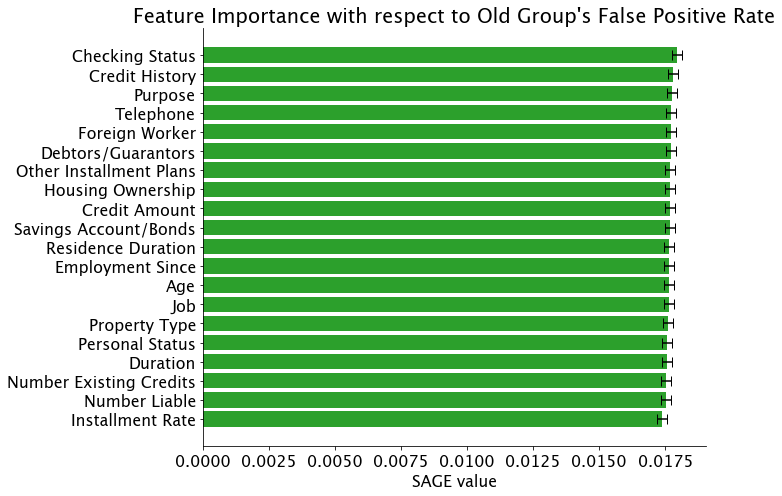

In [19]:
sage_values_old_fpr.plot(feature_names, title='Feature Importance with respect to Old Group\'s False Positive Rate')